In [6]:
import numpy as np
import torch
import torchvision as torchvision
import multiprocessing

# seed_all(42)

In [21]:
num_workers = multiprocessing.cpu_count()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_len = int(len(train_dataset) * 0.8)
val_len = len(train_dataset) - train_len
print(train_len, val_len)
batch_size = 1024
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

print(len(train_subset))
train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

48000 12000
48000


In [10]:
from PIL import Image

target_digits = {
        0: Image.open('./target/0.png'),
        1: Image.open('./target/1.png'),
        2: Image.open('./target/2.png'),
        3: Image.open('./target/3.png'),
        4: Image.open('./target/4.png'),
        5: Image.open('./target/5.png'),
        6: Image.open('./target/6.png'),
        7: Image.open('./target/7.png'),
        8: Image.open('./target/8.png'),
        9: Image.open('./target/9.png')
    }

sourceToMNIST = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize((28,28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.functional.invert,
    # torchvision.transforms.ToPILImage()
])
target_digits = {key: sourceToMNIST(target_digits[key])  for key in target_digits}

def labels_to_perfect_images(labels: list[int]):
    perfect_images =  [target_digits[label] for label in labels]

    return perfect_images

In [11]:

import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, encoding_dim*2),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim*2),
            nn.Linear(encoding_dim*2, encoding_dim), 
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(), 
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid() 
        )
    
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),
            self.encoder,
            self.decoder
        ) 
 

    def forward(self, x):
        encoded = self.auto_encoder(x)
        return encoded.reshape((x.shape[0], 1, 28, 28))
    

encoding_dim = 64
model = Autoencoder(encoding_dim)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [23]:
from tqdm import tqdm

n_epochs = 20

for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    model.train()
    for data in tqdm(desc="Training", total=len(train_loader), iterable=train_loader):
        images, labels = data

        optimizer.zero_grad()
        outputs = model(images)
        perfect_images = labels_to_perfect_images(labels.flatten().numpy())
        flatOut = outputs.flatten()
        target = torch.nn.utils.rnn.pad_sequence(perfect_images).reshape(flatOut.shape)
        
        loss = criterion(flatOut, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(val_loader), iterable=val_loader):
            images, labels = data

            outputs = model(images)
            flatOut = outputs.flatten()
            perfect_images = labels_to_perfect_images(labels.flatten().numpy())
            loss = criterion(flatOut, torch.nn.utils.rnn.pad_sequence(perfect_images).reshape(flatOut.shape))
            
            val_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch: 1 	Training Loss: 41.367278	Valid Loss: 12.796946


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch: 2 	Training Loss: 9.731967	Valid Loss: 7.735995


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Epoch: 3 	Training Loss: 6.776532	Valid Loss: 5.996860


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch: 4 	Training Loss: 5.457111	Valid Loss: 5.292846


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Epoch: 5 	Training Loss: 4.534244	Valid Loss: 4.488575


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch: 6 	Training Loss: 3.718775	Valid Loss: 3.861549


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch: 7 	Training Loss: 3.133602	Valid Loss: 3.393440


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch: 8 	Training Loss: 2.499015	Valid Loss: 3.071866


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch: 9 	Training Loss: 2.194275	Valid Loss: 2.661909


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch: 10 	Training Loss: 1.855537	Valid Loss: 2.512886


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch: 11 	Training Loss: 1.674360	Valid Loss: 2.535558


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch: 12 	Training Loss: 1.454961	Valid Loss: 2.466091


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch: 13 	Training Loss: 1.344770	Valid Loss: 2.418835


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch: 14 	Training Loss: 1.189817	Valid Loss: 2.274889


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Epoch: 15 	Training Loss: 1.096979	Valid Loss: 2.369079


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch: 16 	Training Loss: 1.072974	Valid Loss: 2.338596


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Epoch: 17 	Training Loss: 1.019341	Valid Loss: 2.203417


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch: 18 	Training Loss: 0.924469	Valid Loss: 2.275704


Validating: 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Epoch: 19 	Training Loss: 0.890045	Valid Loss: 2.141075


Validating: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]

Epoch: 20 	Training Loss: 0.847154	Valid Loss: 2.098960


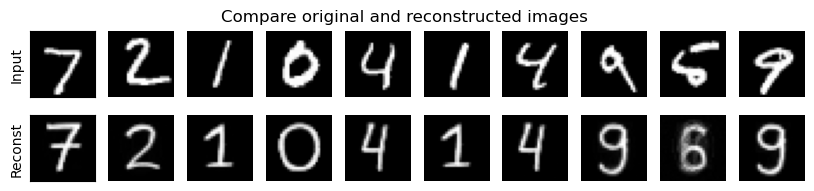

In [44]:
import matplotlib.pyplot as plt

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=10, num_workers=num_workers)

dataiter = iter(test_loader)
images, _ = next(dataiter)

model.eval()
with torch.no_grad():
    model_result = model(images)
    fig, subs = plt.subplots(2, 10, figsize=(10, 2))
    for img, sub in zip(images, subs[0].flatten()):
        sub.imshow(img[0, ...], cmap='gray')
        sub.axis("off")
    for rec, sub in zip(model_result, subs[1].flatten()):
        sub.imshow(rec[0, ...], cmap='gray')
        sub.axis("off")
    fig.suptitle("Compare original and reconstructed images")

    subs[0][0].set_ylabel("Input")
    subs[0][0].axis("on")
    subs[0][0].set_xticks([])
    subs[0][0].set_yticks([])
    
    subs[1][0].axis("on")
    subs[1][0].set_xticks([])
    subs[1][0].set_yticks([])
    subs[1][0].set_ylabel("Reconst")

    plt.show()